In [1]:
import sklearn #software machine learning library for the Python programming language.
from sklearn import model_selection 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,KFold, train_test_split
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

Here I will be using the quality values as they are without transform it to binary values, which means we will have 6 classes of the wine quality. Where the quality column contains 6 values

In [2]:
# load the csv file as a data frame
df = pd.read_csv('/Users/grace/Desktop/Courses/Master_thesis/Datsets/redwinequality.csv')

# Separate the target variable
X = df.drop('quality', axis=1) #represent the input features
y = df['quality']  #represent the target variable 

In [20]:
#The train_test_split function takes as input the input features X and target variable y, and returns four arrays
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# Initialize the Random Forest Classifier
cls = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [22]:
from sklearn.metrics import accuracy_score

# Make predictions on the training and test data
y_train_pred = cls.predict(X_train)
y_train_prob = cls.predict_proba(X_train)[:, 1]
y_test_pred = cls.predict(X_test)
y_test_prob = cls.predict_proba(X_test)[:, 1]

# Calculate the accuracy of the predictions to test the ability of a machine learning model to predict new data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the train and test accuracy
print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Train accuracy: 0.946051602814699
Test accuracy: 0.64375


alcohol                 0.172200
sulphates               0.116912
total sulfur dioxide    0.109343
volatile acidity        0.097413
density                 0.093359
chlorides               0.075525
fixed acidity           0.073440
residual sugar          0.069864
pH                      0.067708
citric acid             0.064706
free sulfur dioxide     0.059529
dtype: float64


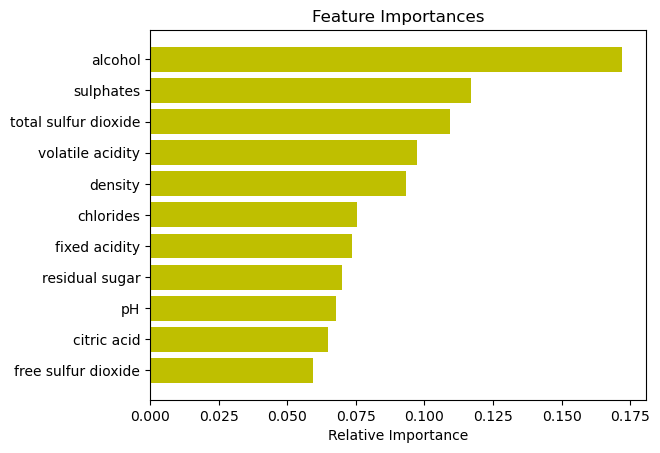

In [23]:
# get the most important features for the model which are the ones that have a strong correlation with the target variable
# By default, the impurity measure used for evaluating the quality of the splits in each decision tree is the Gini impurity
importances = pd.Series(cls.feature_importances_, index=X_train.columns)
# Print feature importance
print(importances.sort_values(ascending=False))

#plot the importances
indices = np.argsort(importances)
features = df.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='y', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance') 
plt.show()

In [24]:
# Select the top 10 features based on feature importance
top_features = importances.sort_values(ascending=False)[:10].index

# Create a new X dataframe with only the top 10 features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Train a new model using only the top 10 features
cls_top = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
cls_top.fit(X_train_top, y_train)

# Make predictions on the test set using the new model
y_test_pred_top = cls_top.predict(X_test_top)
y_train_pred_top = cls_top.predict(X_train_top)

# Evaluate the performance of the new model
test_accuracy_top = accuracy_score(y_test, y_test_pred_top)
train_accuracy_top = accuracy_score(y_train, y_train_pred_top)
print('Train accuracy with top 10 features:', train_accuracy_top)
print('Test accuracy with top 10 features:', test_accuracy_top)



Train accuracy with top 10 features: 0.6950742767787333
Test accuracy with top 10 features: 0.5625


In [18]:
# Hyperparameter Tuning: Use the validation set to tune the model's hyperparameter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [2, 4, 5, 6, 8, 10, 15],
    'n_estimators': [10, 50, 100, 150, 200]
}
# Create a Random Forest Classifier object
rfc = RandomForestClassifier(random_state=42)
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5) # cv is set to 5 to perform a 5-fold cross-validation during the search.
# Train the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)
# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': 15, 'n_estimators': 150}


In [25]:
# Evaluate the performance of the model on the validation set

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# .score: This method internally uses the best hyperparameters found during the grid search (grid_search.best_params_) to train a new model on the training set 
# and computes the accuracy of this model on the validation set 
accuracy = grid_search.score(X_val, y_val)
print(f'Validation accuracy: {accuracy:.4f}')

Validation accuracy: 1.0000


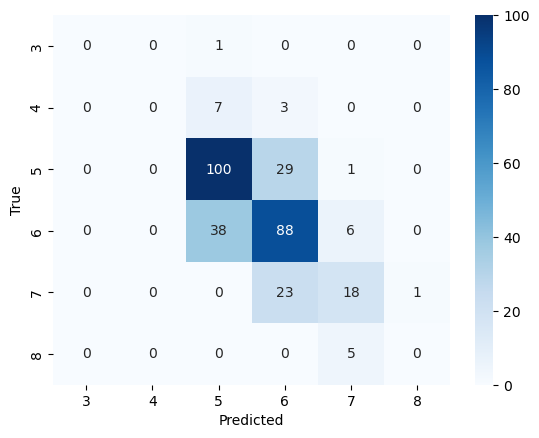

In [38]:
#A confusion matrix summarizes the performance of a classification model on a set of test data for which the true values are known
from sklearn.metrics import confusion_matrix
import seaborn as sns # we need a heatmap from the seaborn library to visualize the confusion_matrix

# Compute the confusion matrix for the test data
y_test_pred = cls.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap, the values in each cell of the heatmap represent the number of test instances that belong to the corresponding true and predicted classes

#The annot=True parameter adds the values to each cell 
# fmt='g' specifies that the values should be displayed as integers
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=cls.classes_, yticklabels=cls.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Explanation part using SHAP

SHAP values measure the contribution of each feature to the difference between the actual model output and the expected model output while considering the presence or absence of the feature. In other words, the SHAP value measures the difference in the model output that can be attributed to the presence or absence of a particular feature, relative to the expected model output.

* The model output refers to the predicted value or probability that the model assigns to a given input instance. 
* The expected model output is the average prediction that the model makes on the training set; It is computed by taking the mean of the output values (i.e., the target variable values) of the training set.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


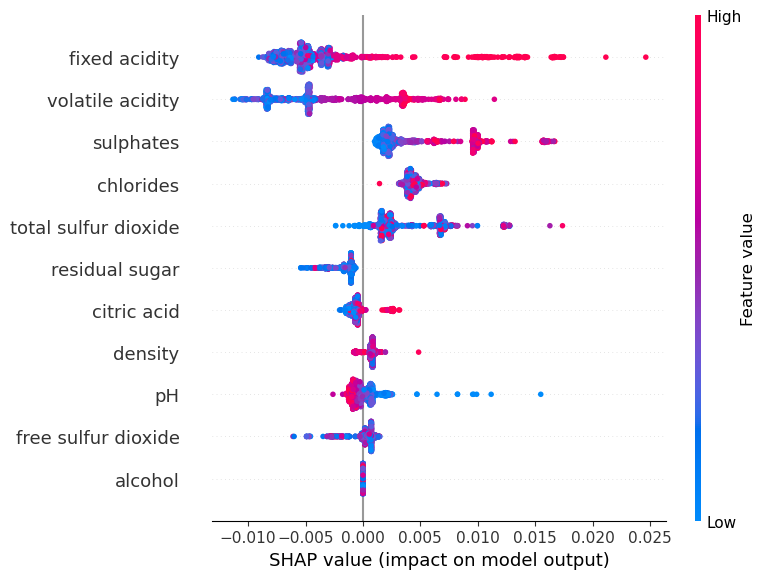

In [42]:
#We can use which RF we wanna use/cls, cls_top, or grid_search.best_params_/ and that's depending on what we want
explainer = shap.TreeExplainer(cls_top) #The TreeExplainer object computes the SHAP values of the features for a specific instance.
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values[5], X.values, feature_names = X.columns) # We can change the shap_value[1] between 0-5 if we wanna see the features' contribution on other classes
#The x-axis stands for the average of the SHAP value of each feature.

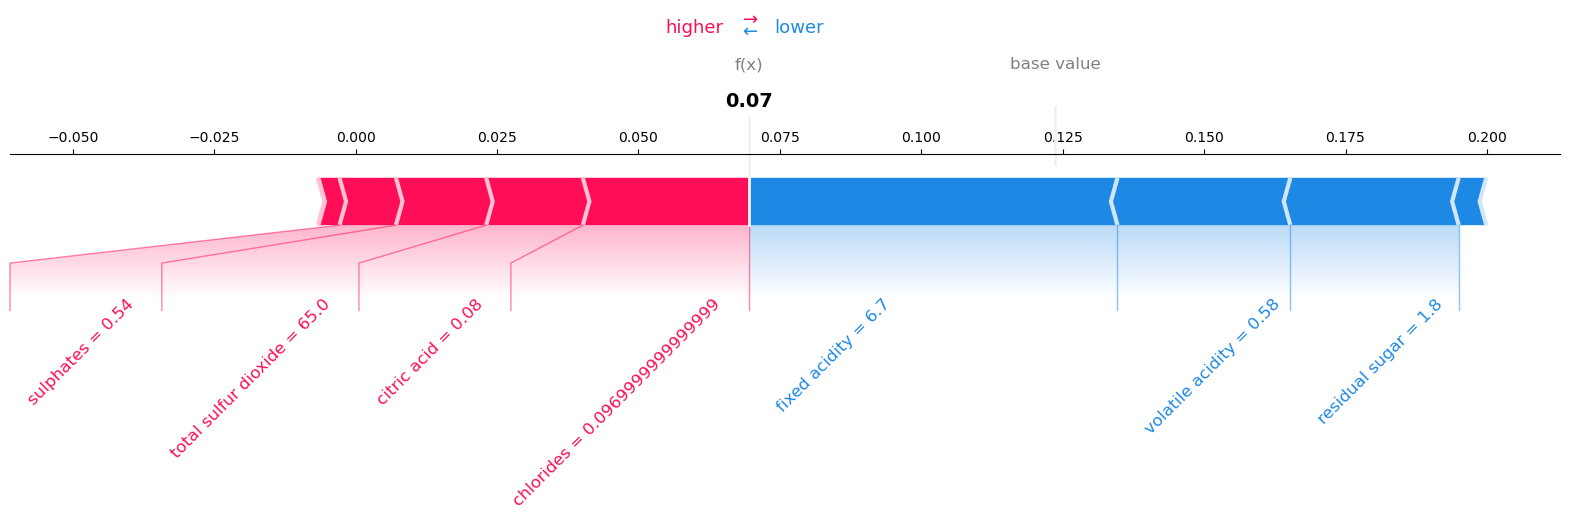

In [55]:
#Explaining specific instance 
# Select a specific instance from the dataset
instance_to_explain = X.iloc[10]

# Compute the SHAP values for the selected instance
shap_values = explainer.shap_values(instance_to_explain)


# Plot the SHAP values for the selected instance, The resulting plot shows how each feature contributes to the final output of the model for the selected instance.
shap.initjs() #This initializes the Javascript visualization library for displaying the SHAP plot in the notebook
shap.force_plot(explainer.expected_value[4], shap_values[4], instance_to_explain, matplotlib=True, text_rotation=45, figsize=(20,4))

# The base_value parameter specifies the expected value of the model output for the base case, which is the mean of the output for the training data on the given class
# the shap_values parameter is the SHAP values for the features of the instance for that class.

